# Sensitivity to the number of EOFs included in truncation: 

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
import pickle as pickle

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [5]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [6]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [7]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
#    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [8]:
ntrunc_list = [5,10,15,20,25,30,35] # EOF truncation for individual fields (reduced-state space)
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic_list = [5,10,15,20,25,30,35]
#modes_sic = 20

mo='all'
#mo=0

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
#date_of_interest = '20211019'
#date_of_interest = '20211027'
date_of_interest = '20211107'
#date_of_interest = '20211015'

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/'

In [9]:
for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    folder = 'reanalysis/'
    filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
                '_'+date_of_interest+'.pkl')

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------
    
    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    ax = axs.flatten()

    plot_lagged_performance_1var(fig,ax[0],'sic',forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin)
    plot_monthly_performance_1var(fig,ax[1],'sic',forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin)
    

    if exp_setup['Insamp']==True:     
        plt.suptitle(('LIM trained on all months: Neofs = '+str(ntrunc)+'\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                     ', Validation years: Historical'), fontsize=16)
    else: 
        plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': Neofs = '+str(ntrunc)+'\n Training years: '+
                      tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                      vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_xlabel('Lag (months)', fontsize=14)
    
    ax[1].legend(loc='lower right', fontsize=14)
    ax[1].set_xlabel('Lag (months)', fontsize=14)
    ax[1].set_ylabel('Global mean RMSE', fontsize=14)

    plt.subplots_adjust(top=0.85)

FileNotFoundError: [Errno 2] No such file or directory: 'reanalysis/Validation_cesm_lme_ntrain_1979_2004_validyrs_2005_2020_sic5_20211107.pkl'

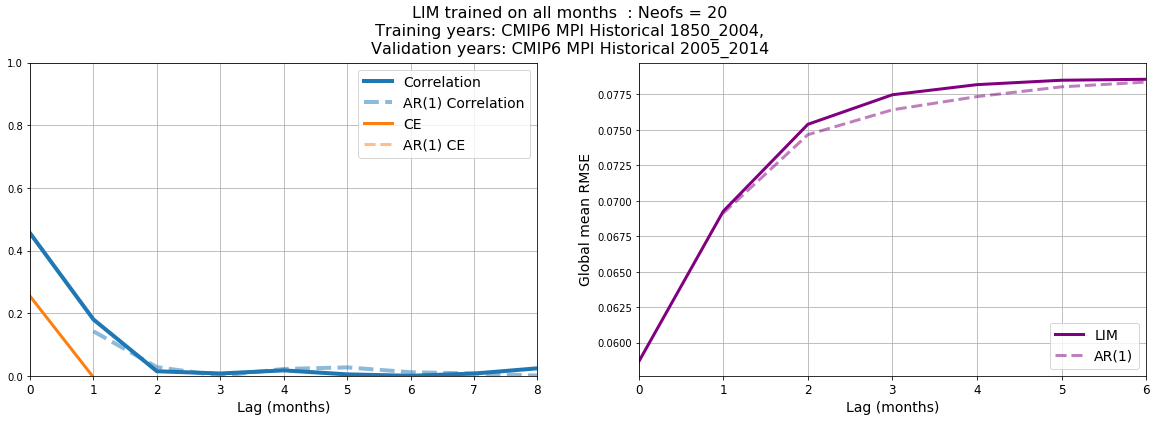

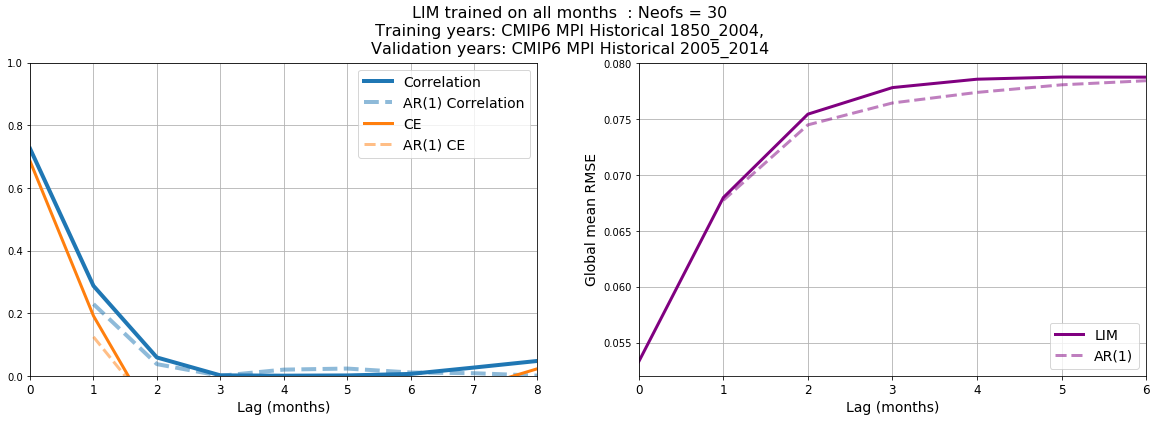

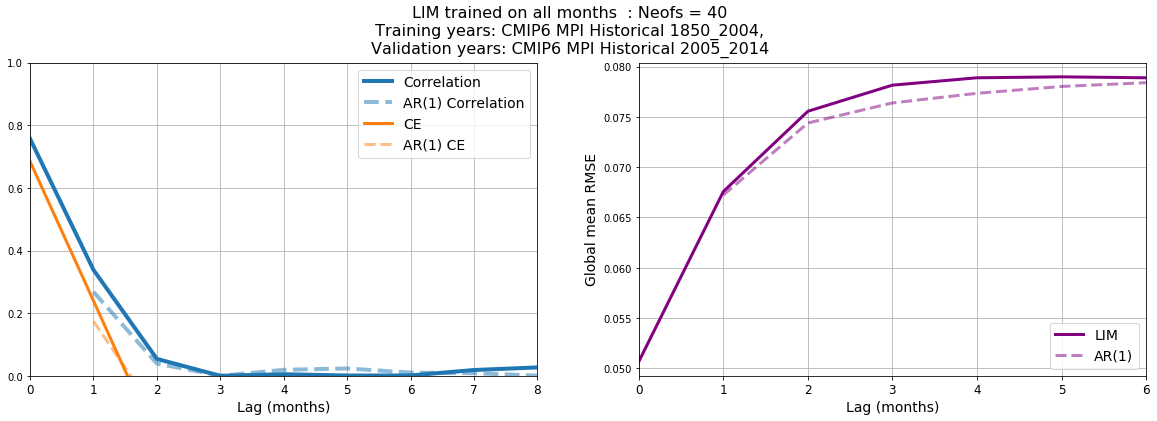

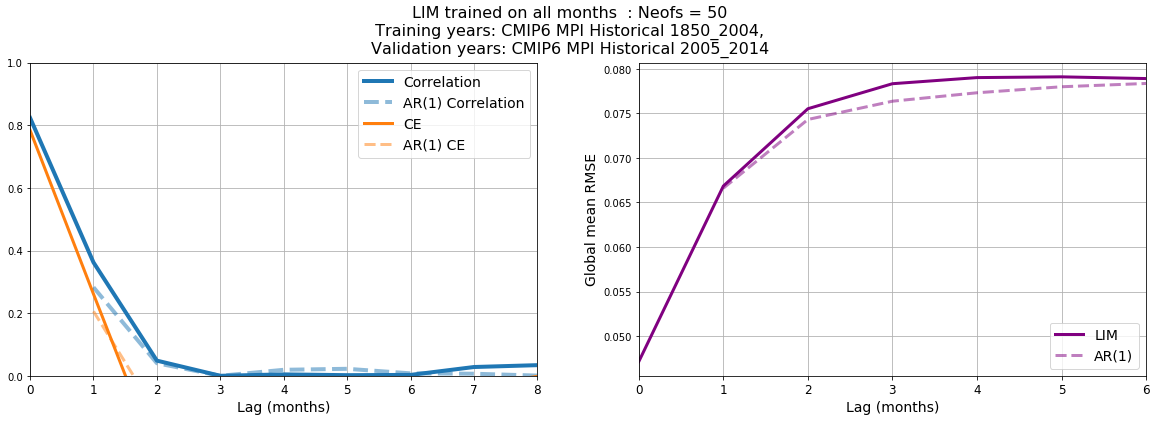

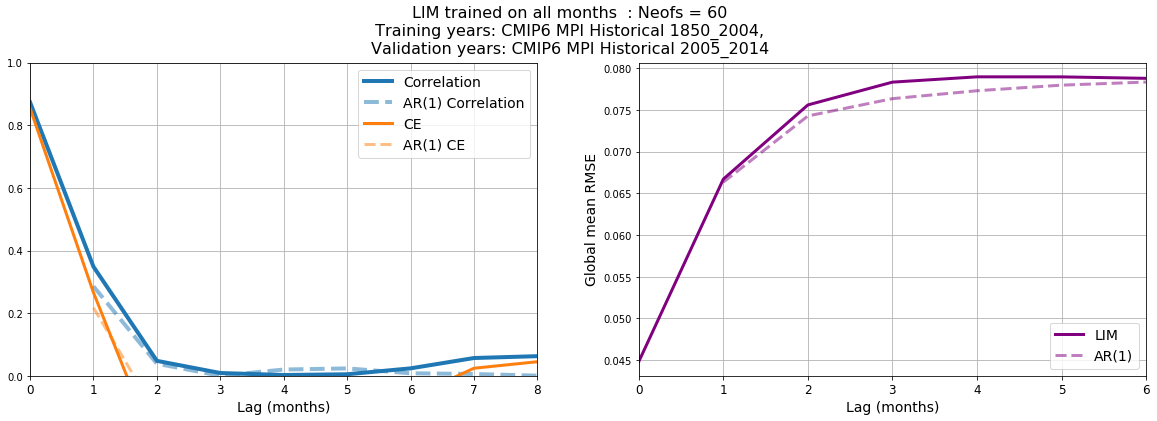

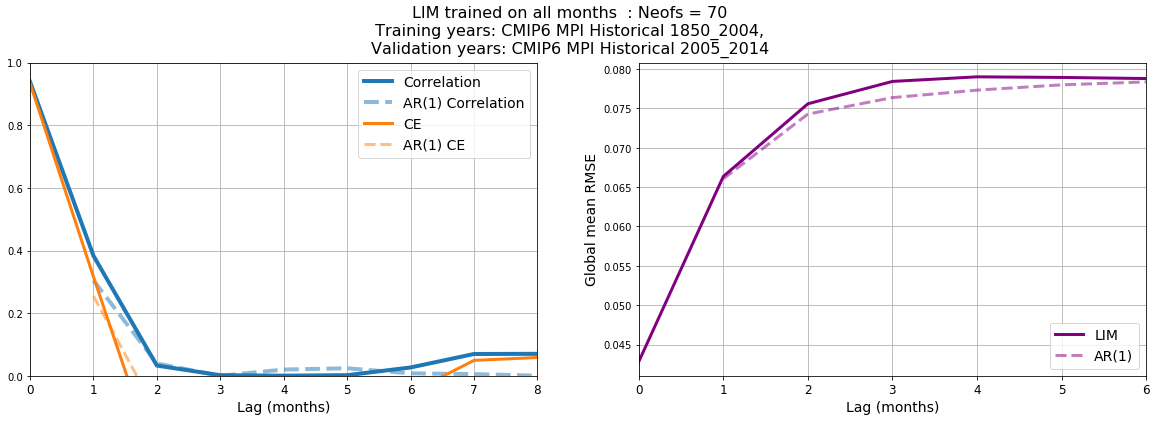

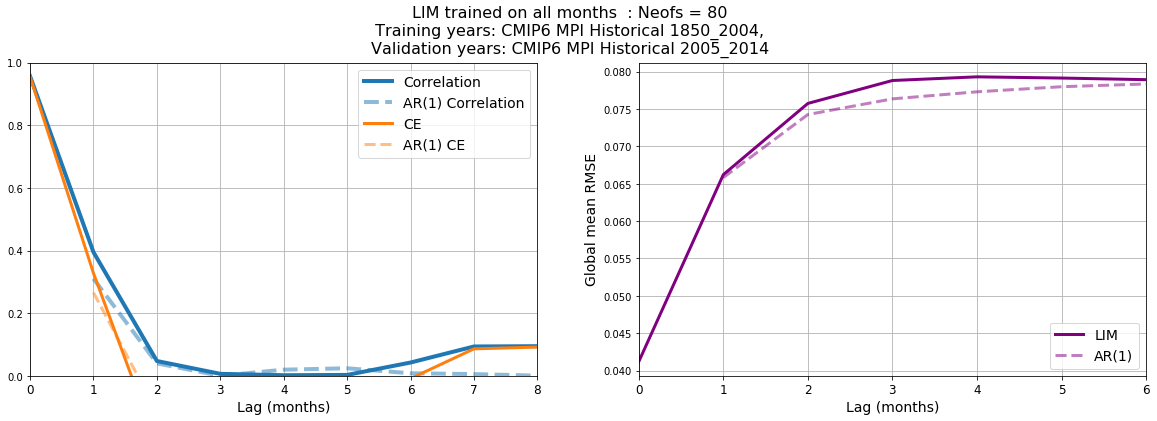

In [30]:
for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    #folder = 'reanalysis/'
    #filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
    #             '_'+date_of_interest+'.pkl')
    folder='historical/'
    filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tas'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------
    
    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    ax = axs.flatten()

    
    plot_lagged_performance_1var(fig,ax[0],'sic',forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin)
    plot_monthly_performance_1var(fig,ax[1],'sic',forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin)
    

    if exp_setup['Insamp']==True:     
        plt.suptitle(('LIM trained on all months: Neofs = '+str(ntrunc)+'\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                     ', Validation years: Historical'), fontsize=16)
    else: 
        plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': Neofs = '+str(ntrunc)+'\n Training years: '+
                      tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                      vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_xlabel('Lag (months)', fontsize=14)
    
    ax[1].legend(loc='lower right', fontsize=14)
    ax[1].set_xlabel('Lag (months)', fontsize=14)
    ax[1].set_ylabel('Global mean RMSE', fontsize=14)

    plt.subplots_adjust(top=0.85)

In [31]:
ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1]

array([1.97930909, 2.0169851 , 2.03042743, 2.0361203 , 2.04682796,
       2.05620893, 2.06581453, 2.07221075])

In [34]:
ar1cast_lags['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1],

(array([0.06582864, 0.07426831, 0.07636343, 0.07730882, 0.07798959,
        0.07835723, 0.07853537, 0.0787019 ]),)

In [17]:
ntrunc_list = [5,10,15,20,25,30,35,40,60,70,80,90,100] # EOF truncation for individual fields (reduced-state space)
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic_list = [5,10,15,20,25,30,35,40,60,70,80,90,100]
#modes_sic = 20

mo='all'
#mo=0

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
#date_of_interest = '20211019'
#date_of_interest = '20211027'
date_of_interest = '20211113'
#date_of_interest = '20211015'

end_trainyr = '1650'

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/'

In [18]:
#colors = ['royalblue','purple', 'c', 'orange', 'green','navy','sienna','grey','k']

cmap = matplotlib.cm.get_cmap('plasma')

move = 1/len(nmodes_sic_list)
colors = [cmap(i) for i in np.arange(0.0,1.1,move)]

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas10_psl10_tos10_sit10_sic10_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas15_psl15_tos15_sit15_sic15_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas20_psl20_tos20_sit20_sic20_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas25_psl25_tos25_sit25_sic25_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas30_psl30_tos30_sit30_sic30_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast

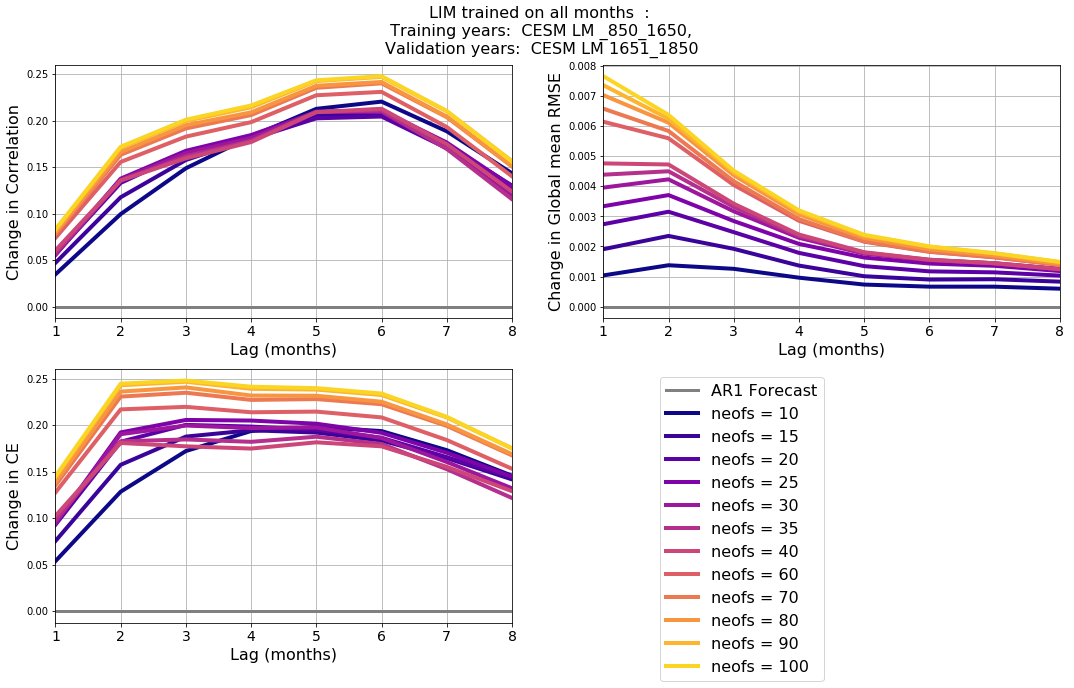

In [14]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[1].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[2].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]
    
    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)

#     folder = 'historical/'
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                 '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                 '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#               '_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     if n<2:
#         filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
#                     '_'+date_of_interest+'.pkl')
#     else: 
#         filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
# #     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
# #                 '_'+date_of_interest+'.pkl')

    folder = 'last_millennium/'
#     filename = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_1351_1361_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    filename = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename)

    experiment =  pickle.load(open(data_dir+folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ar1_corr = ar1cast_lags['validation_stats_ar1_lags']['sic']['corr_tot'][:-1]
    ar1_ce = ar1cast_lags['validation_stats_ar1_lags']['sic']['ce_tot'][:-1]
    ar1_gm_rmse = ar1cast_lags['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

    corr_diff = forecast_validation_lags['validation_stats_lags']['sic']['corr_tot'][1:] - ar1_corr
    ce_diff = forecast_validation_lags['validation_stats_lags']['sic']['ce_tot'][1:] - ar1_ce
    rmse_diff = ar1_gm_rmse - forecast_validation_lags['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[0].plot(exp_setup['lags'][1:],corr_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup['lags'][1:],ce_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[1].plot(exp_setup['lags'][1:],rmse_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    

ax[1].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[1].set_yticklabels(np.arange(-0.00041,0.00041,0.0002),fontsize=14)
#ax[1].set_ylim(-0.0001,0.003)
#ax[1].set_ylim(-0.00005,0.00005)
ax[1].set_xlim(1,8)
ax[1].grid(axis='both')

# ax[0].set_xticks(np.arange(0,8,1))
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[0].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[0].set_ylim(-0.5,0.5)
#ax[0].set_ylim(-0.25,0.25)
ax[0].set_xlim(1,8)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[2].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[2].set_ylim(-0.5,0.5)
#ax[2].set_ylim(-0.25,0.25)
ax[2].set_xlim(1,8)
ax[2].grid(axis='both')

# ax[3].xaxis.set_visible(False) 
# ax[3].yaxis.set_visible(False)
ax[3].axis('off')
    
if exp_setup['Insamp']==True:     
    plt.suptitle(('LIM trained on all months:\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': \n Training years: '+
                  tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                  vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Correlation', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in CE', fontsize=16)

#ax[3].legend(loc='upper left', fontsize=14)
ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)
ax[1].set_xlabel('Lag (months)', fontsize=16)
ax[1].set_ylabel('Change in Global mean RMSE', fontsize=16)

plt.subplots_adjust(top=0.90)

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas5_psl5_tos5_sit5_sic5_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas5_psl5_tos5_sit5_sic5_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas10_psl10_tos10_sit10_sic10_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas10_psl10_tos10_sit10_sic10_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas15_psl15_tos15_sit15_sic15_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas15_psl15_tos15_sit15_sic15_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_c

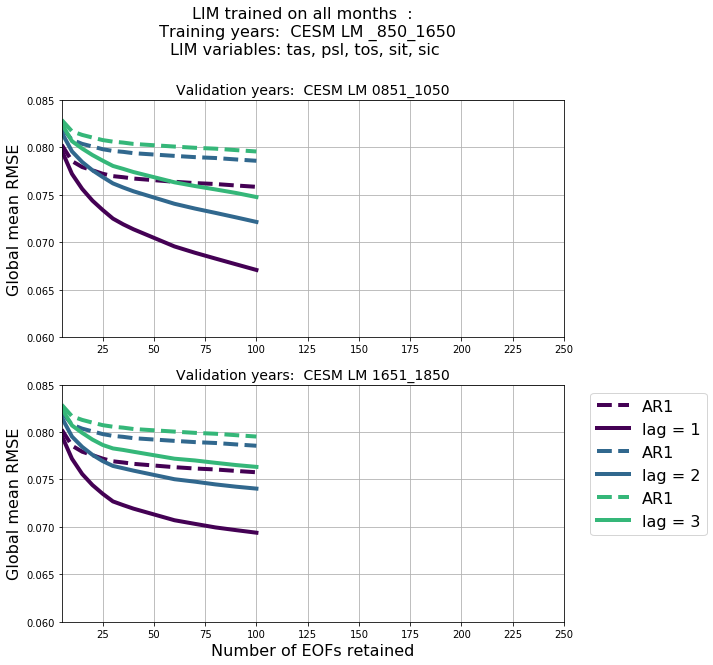

In [19]:
cmap = matplotlib.cm.get_cmap('viridis')

move = 1/3
colors_lags = [cmap(i) for i in np.arange(0.0,1.1,move)]

fig,axs = plt.subplots(2,1,figsize=(9,10))
ax = axs.flatten()

rmse_ar1_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_ar1_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

rmse_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]
    
    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)

#    folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     if n <2:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)+
#                   '_'+date_of_interest+'.pkl')
#     else:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                         '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'last_millennium/'
#     filename_os = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_1351_1361_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_0852_0862_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
    filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                   '_'+date_of_interest+'.pkl')
    filename_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_'+var_names+
                   '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    ar1_gm_rmse_is = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    ar1_gm_rmse_os = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    
    rmse_ar1_tot_is[n,:] = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    rmse_ar1_tot_os[n,:] = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    
    rmse_tot_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_tot_os[n,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]

    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

for i in np.arange(1,4,1):
    ax[0].plot(np.array(ntrunc_list),rmse_tot_is[:,i],
               label=('lag = '+str(i)),linewidth=4.0, color=colors_lags[i-1])
    ax[0].plot(np.array(ntrunc_list),rmse_ar1_tot_is[:,i],
               label=('AR1'),linewidth=4.0, linestyle='--',color=colors_lags[i-1])
    ax[1].plot(np.array(ntrunc_list),rmse_ar1_tot_os[:,i],
               label=('AR1'),linewidth=4.0,linestyle='--',color=colors_lags[i-1]) 
    ax[1].plot(np.array(ntrunc_list),rmse_tot_os[:,i],
               label=('lag = '+str(i)),linewidth=4.0, color=colors_lags[i-1])  

ax[0].set_xticks(np.arange(25,251,25))
#ax[0].set_xticklabels(fontsize=14)
ax[0].set_xlim(5,250)
ax[0].set_ylim(0.06,0.085)
ax[0].grid(axis='both')

ax[1].set_xticks(np.arange(25,251,25))
#ax[1].set_xticklabels(fontsize=14)
ax[1].set_xlim(5,250)
ax[1].set_ylim(0.06,0.085)
ax[1].grid(axis='both')


title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[1].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Number of EOFs retained', fontsize=16)
ax[1].set_ylabel('Global mean RMSE', fontsize=16)

ax[1].legend(bbox_to_anchor=(0.6,0,0.7,1), fontsize=16)

plt.subplots_adjust(top=0.85)

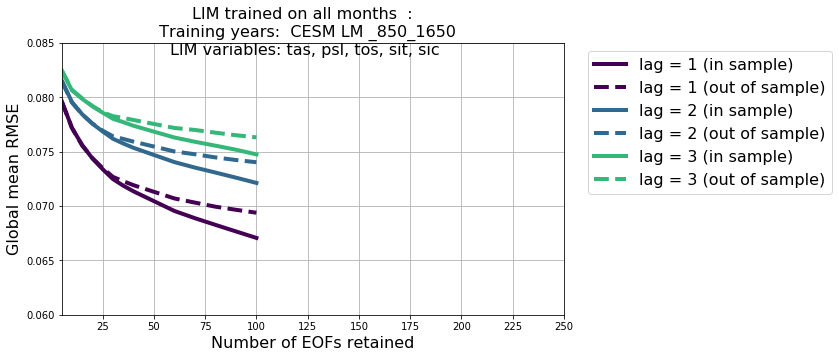

In [20]:
cmap = matplotlib.cm.get_cmap('viridis')

move = 1/3
colors_lags = [cmap(i) for i in np.arange(0.0,1.1,move)]

fig,axs = plt.subplots(1,1,figsize=(9,5))

for i in np.arange(1,4,1):
    plt.plot(np.array(ntrunc_list),rmse_tot_is[:,i],
               label=('lag = '+str(i)+' (in sample)'),linewidth=4.0, color=colors_lags[i-1])
    plt.plot(np.array(ntrunc_list),rmse_tot_os[:,i],linestyle='--',
               label=('lag = '+str(i)+' (out of sample)'),linewidth=4.0, color=colors_lags[i-1])  

plt.xticks(np.arange(25,251,25))
plt.xlim(5,250)
plt.ylim(0.06,0.085)
plt.grid(axis='both')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

plt.ylabel('Global mean RMSE', fontsize=16)
plt.xlabel('Number of EOFs retained', fontsize=16)

plt.legend(bbox_to_anchor=(0.85,0,0.7,1), fontsize=16)

# plt.subplots_adjust(top=0.75)

In [37]:
rmse_tot_is

array([[0.06528948, 0.0729753 , 0.07649806, 0.07827307, 0.07909374,
        0.07942938, 0.0796171 , 0.07977122],
       [0.06383369, 0.07206285, 0.07582646, 0.07772534, 0.07863203,
        0.07901986, 0.07925315, 0.07944592],
       [0.06274916, 0.07144691, 0.07537801, 0.07740741, 0.07837261,
        0.07877534, 0.07902497, 0.07923129],
       [0.06186838, 0.07090159, 0.07496908, 0.07707231, 0.07809356,
        0.07854371, 0.07880345, 0.07900245],
       [0.05886365, 0.06914448, 0.0737213 , 0.07607822, 0.07725614,
        0.07782243, 0.07817151, 0.07842257],
       [0.05779785, 0.06850102, 0.0732376 , 0.07570747, 0.07695392,
        0.07755742, 0.07793567, 0.07821872],
       [0.05685535, 0.0679005 , 0.07279414, 0.0753586 , 0.07666623,
        0.07731963, 0.07773416, 0.07803471],
       [0.05591992, 0.06731236, 0.07233798, 0.07499653, 0.07637659,
        0.07706885, 0.07751737, 0.07783657],
       [0.05508614, 0.06672987, 0.07187303, 0.07457578, 0.07599585,
        0.07674941, 0.077241

In [31]:
nmodes_sic_list [9]

150

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas25_psl25_zg25_tos25_sit25_sic25_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas25_psl25_zg25_tos25_sit25_sic25_20211113.pkl


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas30_psl30_zg30_tos30_sit30_sic30_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas30_psl30_zg30_tos30_sit30_sic30_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas35_psl35_zg35_tos35_sit35_sic35_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas35_psl35_zg35_tos35_sit35_sic35_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas40_psl40_zg40_tos40_sit40_sic40_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas40_psl40_zg40_tos40_sit40_sic40_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity

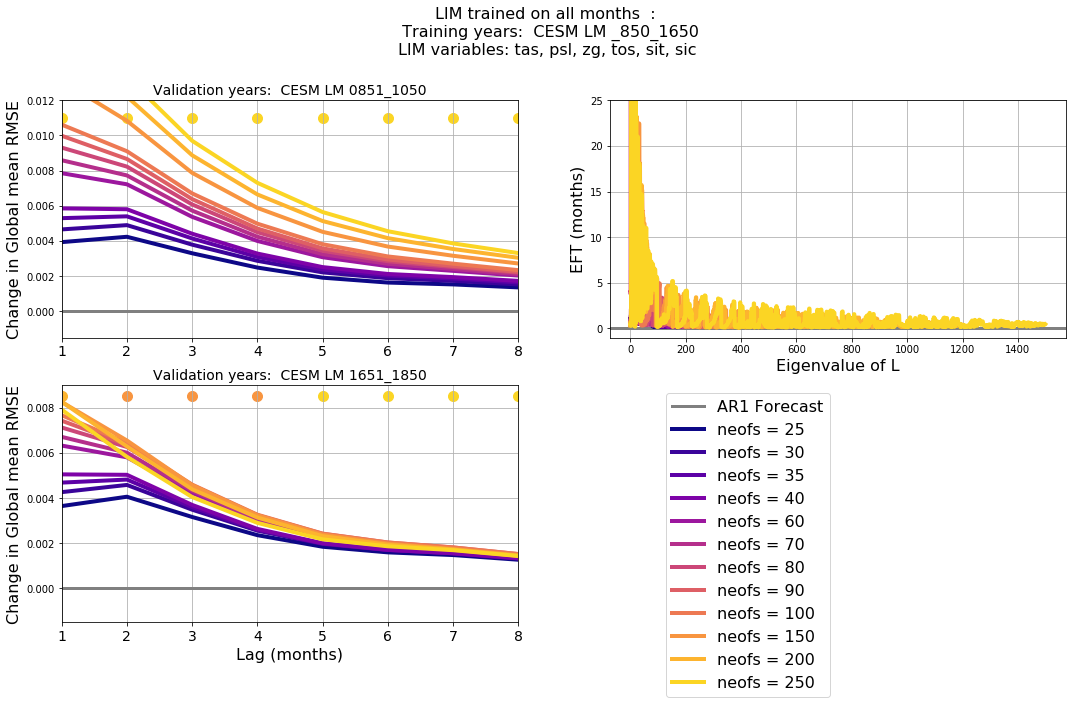

In [13]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[2].axhline(0.0, color='gray', linewidth=3,label='AR1 Forecast')
ax[1].axhline(0.0, color='gray', linewidth=3,label='AR1 Forecast')

rmse_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

rmse_diff_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_diff_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]
    
    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)

#    folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     if n <2:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)+
#                   '_'+date_of_interest+'.pkl')
#     else:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                         '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'last_millennium/'
#     filename_os = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_1351_1361_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_0852_0862_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
    filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                   '_'+date_of_interest+'.pkl')
    filename_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_'+var_names+
                   '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    ar1_gm_rmse_is = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    ar1_gm_rmse_os = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

    rmse_diff_is = ar1_gm_rmse_is - forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_diff_os = ar1_gm_rmse_os - forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    rmse_diff_tot_is[n,:] = rmse_diff_is
    rmse_diff_tot_os[n,:] = rmse_diff_os
    rmse_tot_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_tot_os[n,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[1].plot(-1/(LIMd_is['lam_L']),linewidth=4.0, color=colors[n])
    ax[0].plot(exp_setup_is['lags'][1:],rmse_diff_is,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup_os['lags'][1:],rmse_diff_os,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    

for i,m in enumerate(np.argmin(rmse_tot_is,axis=0)):
    ax[0].scatter(exp_setup_is['lags'][1:][i],0.011,#(np.round(np.max(rmse_diff_tot_is),4)+0.0001),
                  color=colors[m], s=100)  
for i,m in enumerate(np.argmin(rmse_tot_os,axis=0)):
    ax[2].scatter(exp_setup_os['lags'][1:][i],0.0085,#(np.round(np.max(rmse_diff_tot_os),4)+0.0001),
                  color=colors[m],s=100)   
    
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[0].set_xlim(1,8)
ax[0].set_ylim(-0.0015,0.012)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[2].set_xlim(1,8)
ax[2].set_ylim(-0.0015,0.009)
ax[2].grid(axis='both')

ax[1].grid(axis='both')
ax[1].set_ylim(-1,25)

ax[3].axis('off')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[2].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Eigenvalue of L', fontsize=16)
ax[1].set_ylabel('EFT (months)', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)

plt.subplots_adjust(top=0.85)

In [15]:
exp_setup_os['lags'][1:]

[1, 2, 3, 4, 5, 6, 7, 8]

## Results relative to 'sic' only: 

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas25_psl25_zg25_tos25_sit25_sic25_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas25_psl25_zg25_tos25_sit25_sic25_20211113.pkl


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas30_psl30_zg30_tos30_sit30_sic30_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas30_psl30_zg30_tos30_sit30_sic30_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas35_psl35_zg35_tos35_sit35_sic35_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas35_psl35_zg35_tos35_sit35_sic35_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas40_psl40_zg40_tos40_sit40_sic40_20211113.pkl 
    and last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_tas40_psl40_zg40_tos40_sit40_sic40_20211113.pkl
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity

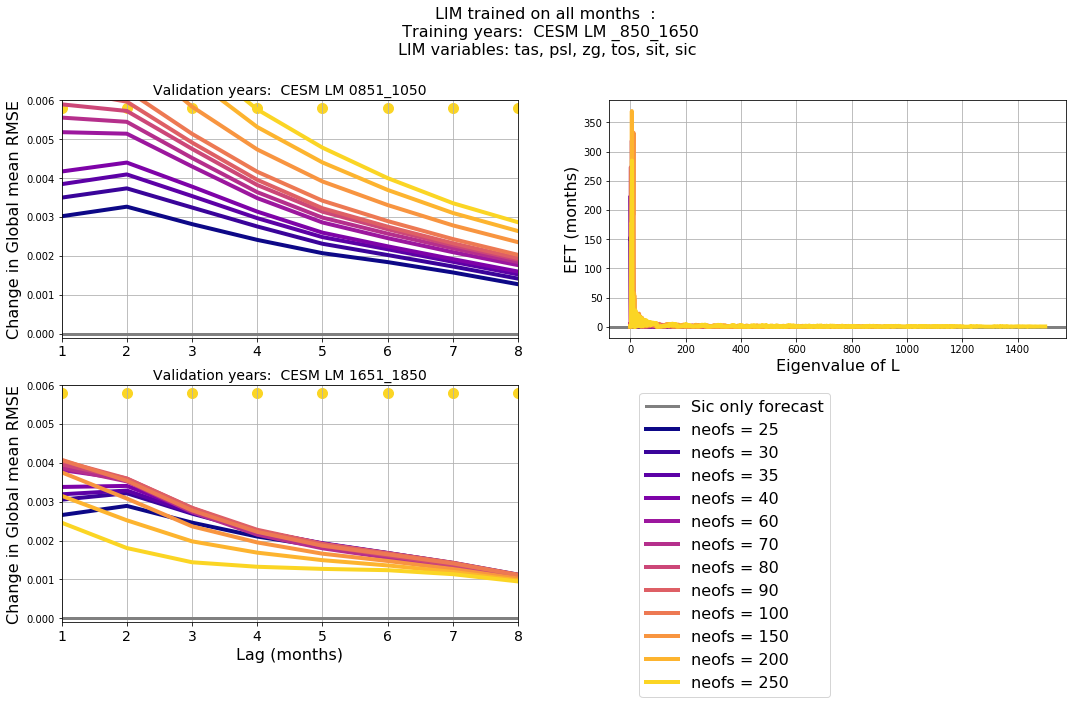

In [14]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')
ax[2].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')
ax[1].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')

rmse_sic_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_sic_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

rmse_diff_sic_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_diff_sic_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)
    
#     folder = 'historical/'
# #     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
# #                 '_'+date_of_interest+'.pkl')
# #     filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
# #               '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                 '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
#     filename_sic_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sic'+str(ntrunc_sic) +'_20211102.pkl')
# #     if n<2:
# #          filename_sic_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)
# #                         +'_20211102.pkl')
# #     else:
#     filename_sic_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)
#                         +'_20211102.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     filename_sic_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_tos'+str(ntrunc_sic)+
#                        '_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_sic_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_tos'+str(ntrunc_sic)+
#                        '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     filename_sic_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_sic_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')

    folder = 'last_millennium/'
    filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                   '_'+date_of_interest+'.pkl')
    filename_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_'+var_names+
                   '_'+date_of_interest+'.pkl')

    filename_sic_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')
    filename_sic_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    experiment_sic_os =  pickle.load(open(data_dir+folder+filename_sic_os, 'rb'))
    experiment_sic_is =  pickle.load(open(data_dir+folder+filename_sic_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    exp_setup_sic_is = experiment_sic_is['forecast']['exp_setup']
    forecast_sic_is = experiment_sic_is['forecast']
    forecast_validation_lags_sic_is = experiment_sic_is['forecast_validation_lags']
    ar1cast_lags_sic_is = experiment_sic_is['ar1cast_lags']
    
    exp_setup_sic_os = experiment_sic_os['forecast']['exp_setup']
    forecast_sic_os = experiment_sic_os['forecast']
    forecast_validation_lags_sic_os = experiment_sic_os['forecast_validation_lags']
    ar1cast_lags_sic_os = experiment_sic_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    sic_only_rmse_is = forecast_validation_lags_sic_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    sic_only_rmse_os = forecast_validation_lags_sic_os['validation_stats_lags']['sic']['gm_rmse'][1:]

    rmse_diff_is = sic_only_rmse_is - forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_diff_os = sic_only_rmse_os - forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    rmse_diff_sic_is[n,:] = rmse_diff_is
    rmse_diff_sic_os[n,:] = rmse_diff_os
    rmse_sic_is[n,:] = sic_only_rmse_is
    rmse_sic_os[n,:] = sic_only_rmse_os
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[1].plot(-1/(LIMd_is['lam_L']),linewidth=4.0, color=colors[n])
    ax[0].plot(exp_setup_is['lags'][1:],rmse_diff_is,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup_os['lags'][1:],rmse_diff_os,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    
for i,m in enumerate(np.argmin(rmse_sic_is,axis=0)):
    ax[0].scatter(exp_setup_is['lags'][1:][i],0.0058,#(np.round(np.max(rmse_diff_sic_is),3)+0.0001),
                  color=colors[m], s=100)  
for i,m in enumerate(np.argmin(rmse_sic_os,axis=0)):
    ax[2].scatter(exp_setup_os['lags'][1:][i],0.0058,#(np.round(np.max(rmse_diff_sic_os),3)+0.0001),
                  color=colors[m],s=100) 
    
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[0].set_xlim(1,8)
ax[0].set_ylim(-0.0001,0.006)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[2].set_xlim(1,8)
ax[2].set_ylim(-0.0001,0.006)
ax[2].grid(axis='both')

ax[1].grid(axis='both')
#ax[1].set_ylim(-5,40)

ax[3].axis('off')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[2].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Eigenvalue of L', fontsize=16)
ax[1].set_ylabel('EFT (months)', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)

plt.subplots_adjust(top=0.85)

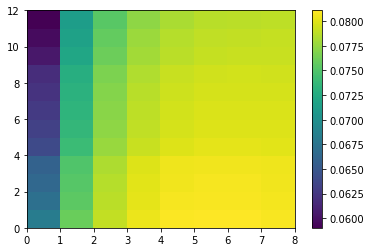

In [20]:
plt.pcolormesh(rmse_sic_os)
plt.colorbar()

In [22]:
rmse_sic_os[:,0:3]

array([[0.06819352, 0.0760294 , 0.07907996],
       [0.06711083, 0.0755517 , 0.07880014],
       [0.06637793, 0.07525865, 0.07860803],
       [0.06588251, 0.07502486, 0.07842075],
       [0.06398038, 0.07406733, 0.07766969],
       [0.06332065, 0.07367009, 0.07734778],
       [0.06275031, 0.07338842, 0.0771768 ],
       [0.06227932, 0.07313627, 0.07696815],
       [0.06185054, 0.07285417, 0.07673278],
       [0.06045503, 0.07206936, 0.07613052],
       [0.05962719, 0.07167785, 0.07582799],
       [0.05901626, 0.07120064, 0.07540318]])

## Spatial Performance: 

In [146]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [147]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [160]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [163]:
n = 6 
ntrunc = ntrunc_list[n]
ntrunc_sic = nmodes_sic_list[n]
var = 'sic'
lag_int = 1

In [164]:
folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#               '_'+date_of_interest+'.pkl')
filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_psl'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_psl'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

#    folder = 'reanalysis/'
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

print('Loading '+folder+filename_os+ ' \n    and '+folder+filename_is)

experiment_os =  pickle.load(open(folder+filename_os, 'rb'))
experiment_is =  pickle.load(open(folder+filename_is, 'rb'))

LIMd_is = experiment_is['LIMd']
exp_setup_is = experiment_is['forecast']['exp_setup']
forecast_is = experiment_is['forecast']
forecast_validation_lags_is = experiment_is['forecast_validation_lags']
ar1cast_lags_is = experiment_is['ar1cast_lags']

Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_psl80_sic80_20211027.pkl 
    and historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_psl80_sic80_20211027.pkl


In [168]:
X_var = load_validation_data(var, exp_setup_is, remove_climo=True, detrend=True, verbose=True)

tecut = 11, tscut = 1.0
Loading from sic
Loading from _SImon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 1860
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with ze

In [170]:
[corr_2d, ce_2d, rmse_2d] = calc_validation_stats_spatial(lag_int,var,X_var,exp_setup_is,forecast_is,LIMd_is)

modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import matplotlib.path as mpath

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    plot_spatial_validation(ax[i], mode, LIMd_is['var_dict'][var]['lat'], 
                            LIMd_is['var_dict'][var]['lon'], mode_name[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

In [143]:
## LOad Truth data: 

fdic_valid = limkb.build_training_dic(exp_setup_is['valid_dsource'])
v = {}
tecut = int(exp_setup_is['nyears_startvalid']/12)+(exp_setup_is['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup_is['nyears_startvalid']/12))

X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                           tscut=int(exp_setup_is['nyears_startvalid']/12), tecut=tecut, 
                           lat_cutoff=exp_setup_is['lat_cutoff'])
        
if var is 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var = X_var/100

tecut = 11, tscut = 1.0
Loading from sic
Loading from _SImon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 1860
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with ze

In [173]:
X_var

In [171]:
## Calculate validation statistics: 
[truth_anom, 
 forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_is['mo'],X_var,
                                                        forecast_is['x_forecast_dcomp'],
                                                        LIMd_is['var_dict'],insamp=exp_setup_is['Insamp'])


print('Truth_anom shape: '+str(truth_anom.shape))
print('Forecast_anom shape: '+str(forecast_anom.shape))

corr=np.zeros(truth_anom.shape[0])
ce=np.zeros(truth_anom.shape[0])

for i in range(truth_anom.shape[0]):
    corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))

AttributeError: 'NoneType' object has no attribute 'shape'

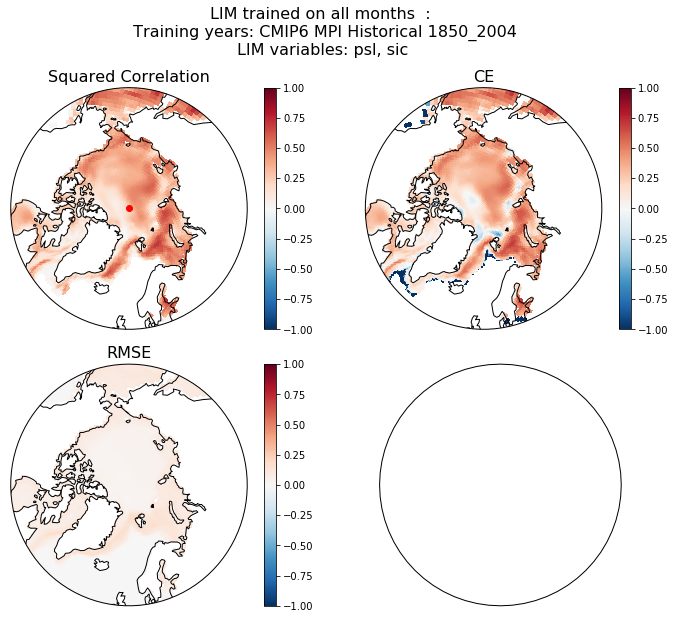

In [145]:
import matplotlib.path as mpath
modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(LIMd_is['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          LIMd_is['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          mode,cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

#ax[0].scatter(lon_plot,lat_plot,color='r')

### inf values in forecast?

In [112]:
sic_forecast = forecast_is['x_forecast_dcomp'][lag_int,LIMd_is['var_dict'][var]['var_inds'],lag_int:]
sic_forecast_2d = np.reshape(sic_forecast,(103,256,119))

In [124]:
np.where(np.isinf(sic_forecast_2d[:,:,0]))

(array([0, 0, 0, ..., 7, 7, 7]), array([ 0,  1,  2, ..., 20, 21, 22]))

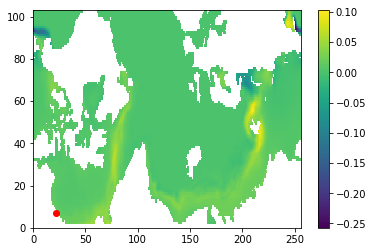

In [125]:
lat_plot = 7
lon_plot = 22

plt.pcolormesh(sic_forecast_2d[:,:,0])
plt.colorbar()
plt.scatter(lon_plot,lat_plot,color='r')

In [121]:
sic_forecast_2d[lat_plot,lon_plot,0]

inf

In [135]:
np.reshape(X_var,(103,256,120))[lat_plot,lon_plot,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])

In [131]:
np.reshape(truth_anom,(103,256,119))[lat_plot,lon_plot,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [130]:
np.reshape(forecast_anom,(103,256,119))[lat_plot,lon_plot,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [128]:
sic_forecast_2d[lat_plot,lon_plot,:]

array([-inf, -inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf, -inf,
       -inf, -inf,  inf, -inf, -inf,  inf,  inf, -inf, -inf, -inf,  inf,
       -inf, -inf,  inf, -inf, -inf, -inf, -inf, -inf,  inf,  inf,  inf,
       -inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf,  inf,  inf,  inf,
        inf,  inf,  inf, -inf, -inf, -inf, -inf, -inf,  inf, -inf, -inf,
       -inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf, -inf, -inf,
       -inf,  inf, -inf,  inf,  inf,  inf, -inf,  inf,  inf,  inf, -inf,
        inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,  inf,  inf,  inf,
       -inf, -inf,  inf,  inf, -inf, -inf, -inf, -inf, -inf,  inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf,  inf, -inf, -inf,  inf,  inf,
       -inf, -inf,  inf,  inf,  inf, -inf,  inf,  inf,  inf])

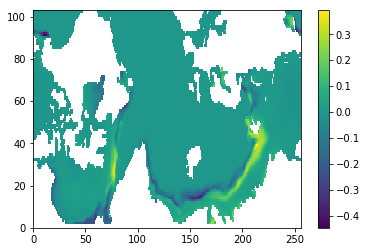

In [137]:
plt.pcolormesh(np.reshape(X_var,(103,256,120))[:,:,0])
plt.colorbar()

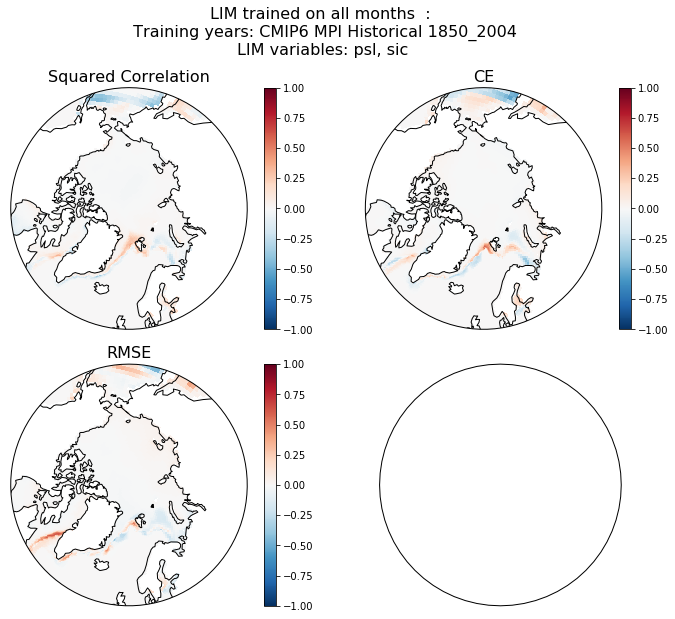

In [139]:
import matplotlib.path as mpath
modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(LIMd_is['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          LIMd_is['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          np.reshape(X_var,(103,256,120))[:,:,i],cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])
